In [18]:
%matplotlib inline
import os
import sys
from tqdm.notebook import tqdm
import torch

sys.path.insert(0, os.path.abspath('../../src/faster_rcnn_fpn'))

In [2]:
# Get through `make metrics`:
import src.evaluators.pascal_voc_evaluator as pascal_voc_evaluator
import src.utils.converter as converter
from src.utils.enumerators import BBFormat, BBType, MethodAveragePrecision

In [3]:
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
from google.cloud import storage
PROJECT_NAME = "pluto-a31d9"
BUCKET_NAME = "pluto-tracking-samples"
client = storage.Client(project=PROJECT_NAME)
bucket = client.get_bucket(BUCKET_NAME)

groundtruth = bucket.get_blob("3_roads_faxe_gt_annotations.csv")
model_output = bucket.get_blob("3_roads_faxe_model_output.csv")

In [5]:
import csv
import pandas as pd
from io import StringIO, BytesIO
annotations_df = pd.read_csv(StringIO(groundtruth.download_as_string().decode("utf-8")))

# Image id is in model output file:
model_output_df = pd.read_csv(StringIO(model_output.download_as_string().decode("utf-8")))

annotations_df = annotations_df.merge(
    model_output_df[['image', 'image_id']].drop_duplicates(['image_id']),
    on='image_id'
)

# "CaptureId" column is expected, we can use the`image_id` as "proxy":
annotations_df["CaptureId"] = annotations_df['image_id']

img_ids = []
img_paths = []
for i, row in annotations_df.drop_duplicates(['image_id'], keep='first').iterrows():
    capture_id = row.image_id
    img_paths.append(f"testdata/images/{row.image}")
    img_ids.append(capture_id)

In [6]:
annotations_df.head(3)

image_id  ClassName  Confidence  X1   X2   Y1  \
0  e4e81487-8128-40c4-a6e2-bd693e4eeba4         13     0.40625   1  146  653   
1  e45d6a0b-5e68-43f7-9df0-eb6d302bb1a8         13     1.00000   2  246  666   
2  732f21b0-c7b8-4165-aecc-bce391eb4c7f         13     1.00000   2  285  680   

    Y2                          AnnotationId label  \
0  795  7106da40-9e87-4d08-bfdc-f93104f040ab   R30   
1  862  c2a95d03-fb5d-44a0-a68f-228aabe35456   R30   
2  890  669a03bd-92f9-46ec-ab91-2967488c50fe   R30   

                                           image  \
0  0001_e4e81487-8128-40c4-a6e2-bd693e4eeba4_img   
1  0040_e45d6a0b-5e68-43f7-9df0-eb6d302bb1a8_img   
2  0066_732f21b0-c7b8-4165-aecc-bce391eb4c7f_img   

                              CaptureId  
0  e4e81487-8128-40c4-a6e2-bd693e4eeba4  
1  e45d6a0b-5e68-43f7-9df0-eb6d302bb1a8  
2  732f21b0-c7b8-4165-aecc-bce391eb4c7f

In [7]:
from tracktor.utils import classes as model_labels
from custom_data import PlutoObjectDetect
import transforms as T


dataset_no_random = PlutoObjectDetect(
    img_ids, img_paths, annotations_df, bucket,
    #osp.join(data_root_dir, 'train'),
    get_transform(train=False))

In [8]:
from tracktor.frcnn_fpn import FRCNN_FPN

obj_detects = []
obj_detect_model = "../../output/custom/faster_rcnn_fpn/training/model_epoch_30.model"
model = FRCNN_FPN(num_classes=31)
model.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detects.append(model)
model.eval()
model.cuda();

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Finding the first image of 483 that has more than 5 labels to display variety


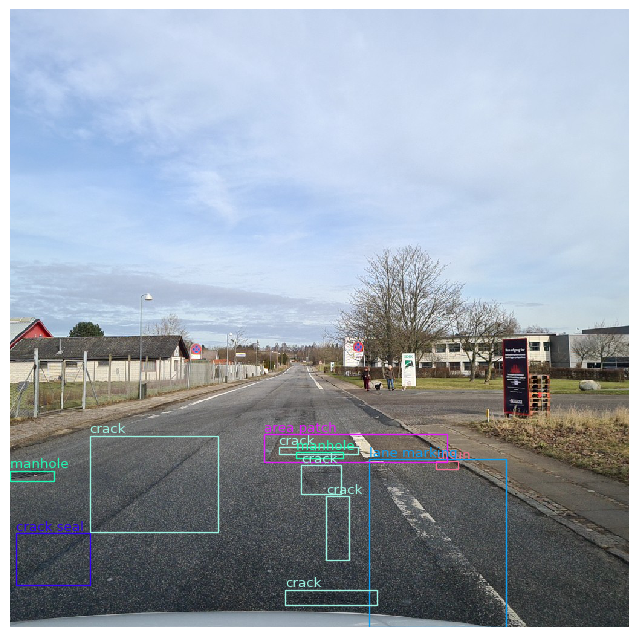

In [19]:
import matplotlib.pyplot as plt
import transforms as T
from tracktor.utils import classes, class_index, rand_cmap

colors = rand_cmap(nlabels=len(annotations_df['ClassName'].unique()),
                   type='bright',
                   first_color_black=False)

def plot(img, boxes, labels):
  fig, ax = plt.subplots(1, dpi=96)

  img = img.mul(255).permute(1, 2, 0).byte().numpy()
  width, height, _ = img.shape
    
  ax.imshow(img, cmap=colors) #cmap='gray')
  #fig.set_size_inches(width / 80, height / 80)
  fig.set_size_inches(width / 120, height / 120)
  for label, box in zip(labels, boxes):
      #color = 1
      rect = plt.Rectangle(
        (box[0], box[1]),
        box[2] - box[0],
        box[3] - box[1],
        fill=False,
        linewidth=1.0,
        color=colors(label))
      ax.add_patch(rect)
      plt.text(box[0], box[1] - 5, classes[class_index[str(label)]], color=colors(label))

  plt.axis('off')
  plt.show()

#dataset = PlutoObjectDetect(osp.join(data_root_dir, 'train'), split_seqs=['MOT17-09'])
dataset = PlutoObjectDetect(img_ids, img_paths, annotations_df, bucket)
num_labels = 5
print(f"Finding the first image of {len(dataset)} that has more than {num_labels} labels to display variety")
index = 0
for img, target in tqdm(dataset):
    if len(set(target['labels'].numpy())) > num_labels: break
    index += 1
        
#img, target = dataset[-15] #-5
img, target = T.ToTensor()(img, target)
plot(img, target['boxes'], target['labels'].numpy())

testdata/images/0001_e4e81487-8128-40c4-a6e2-bd693e4eeba4_img


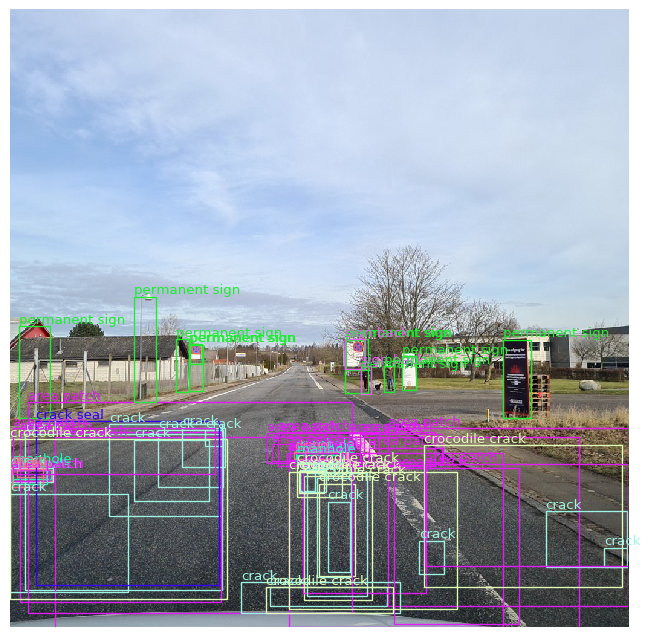

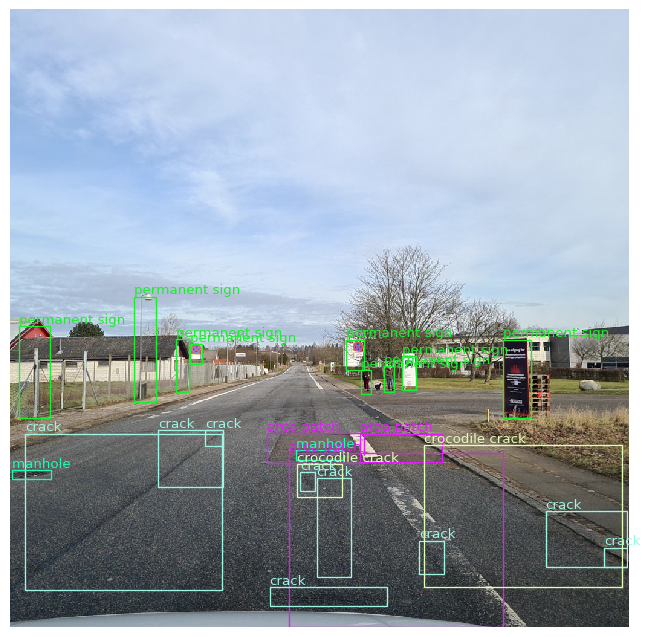

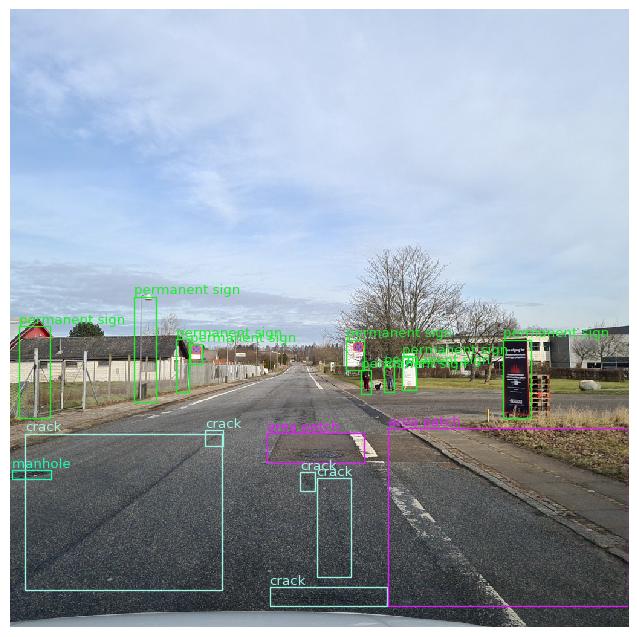

In [20]:
# pick one image from the test set
# The test sets are the images from Hylleholtvej, Strandvejen, and Bækvej
# TODO: A compatible loader for the test set 
from torchvision.ops.boxes import nms
from torch import index_select, masked_select

data_loader = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

count = -1
for imgs, target in tqdm(data_loader):
    count += 1
    if count != index: continue
    print(dataset_no_random._img_paths[0])

    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
    
    # Without non-maximum supression: 
    plot(imgs[0], prediction['boxes'], prediction['labels'].cpu().numpy())
   
    # With 0.2 IoU based non-maximum supression applied
    indices = nms(prediction['boxes'], prediction['scores'], 0.2)
    plot(imgs[0], index_select(prediction['boxes'], 0, indices), index_select(prediction['labels'], 0, indices).cpu().numpy())
     
    # With 0.01 IoU based non-maximum supression applied
    indices = nms(prediction['boxes'], prediction['scores'], 0.01)
    plot(imgs[0], index_select(prediction['boxes'], 0, indices), index_select(prediction['labels'], 0, indices).cpu().numpy())
    
    # Groundtruth
    #plot(imgs[0], target[0]['boxes'], target[0]['labels'].cpu().numpy())
    break

In [21]:
for imgs, target in tqdm(data_loader):
    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
        
    # xyrb pascal VOC format:
    # <class_name> <confidence> <left> <top> <right> <bottom> 
    img_id = img_ids[target[0]['image_id']]
    with open(f"../../output/custom/faster_rcnn_fpn/testing/{img_id}.txt", 'w') as f:
        for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
            x1, y1, x2, y2 = box.cpu().numpy()
            f.write(f"{class_index[str(label.item())]} {score} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n")

In [22]:
dir_gts = '../../data/gt/'
dir_dets = '../../output/custom/faster_rcnn_fpn/testing/'
gt_bbs = converter.text2bb(dir_gts, bb_type=BBType.GROUND_TRUTH, bb_format=BBFormat.XYX2Y2)
det_bbs = converter.text2bb(dir_dets, bb_type=BBType.DETECTED, bb_format=BBFormat.XYX2Y2)

#det_bbs = #converter.yolo2bb(dir_dets,  dir_imgs, filepath_yolo_names, bb_type=BBType.DETECTED)


In [23]:
det_bbs[0].get_area()

77031.0

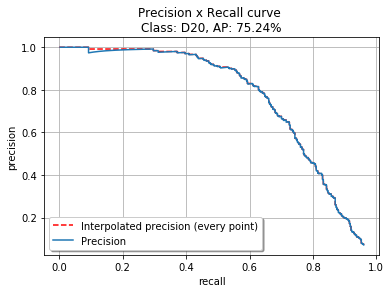

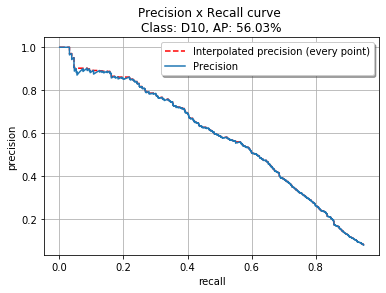

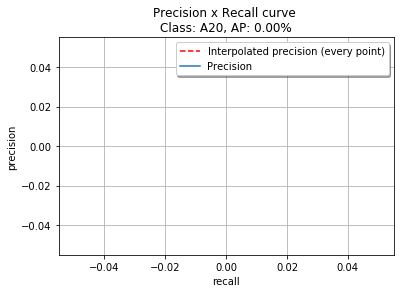

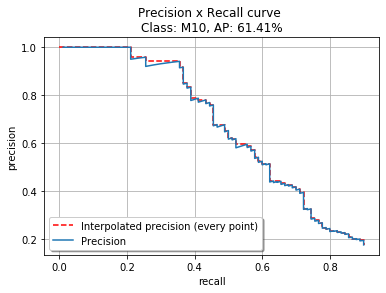

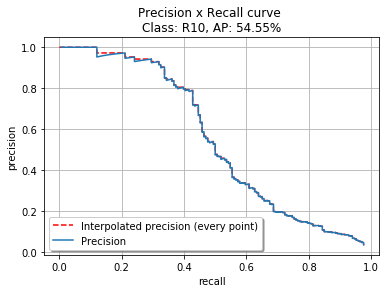

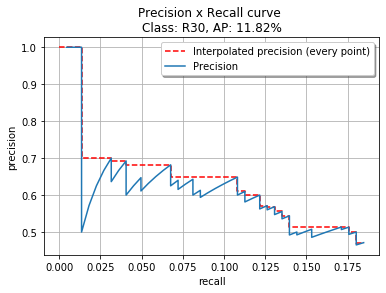

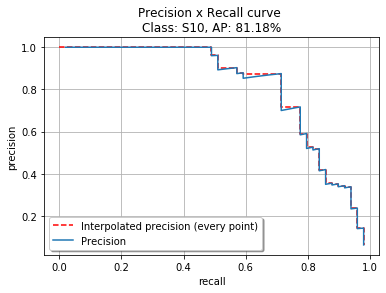

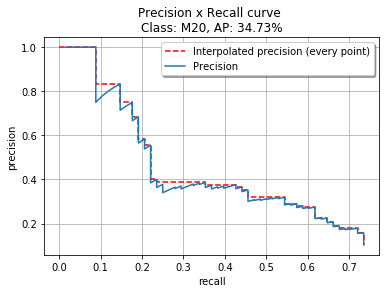

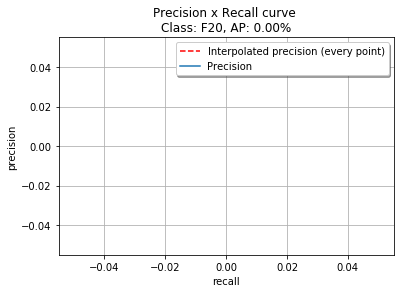

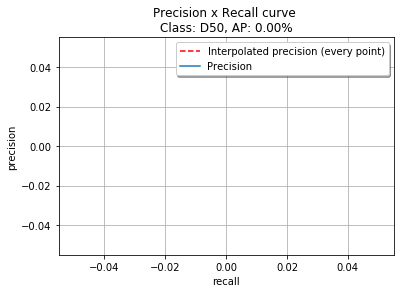

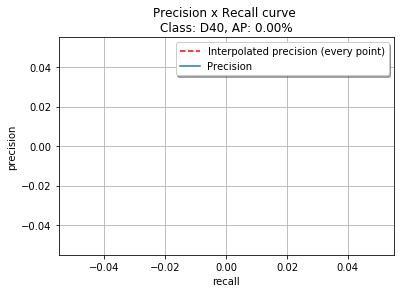

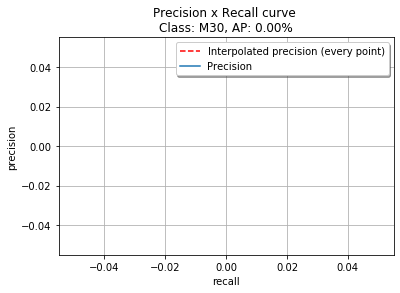

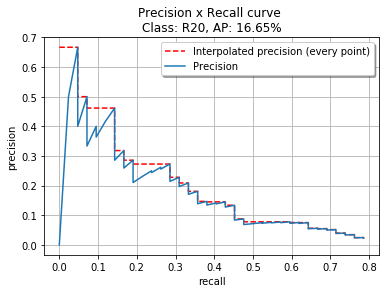

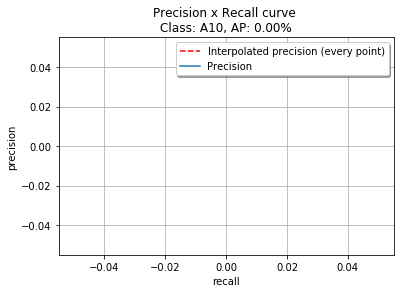

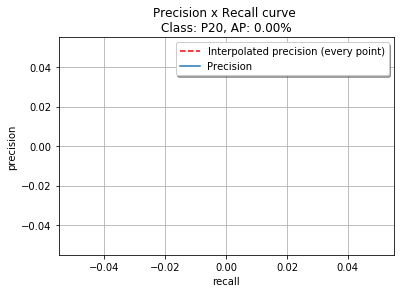

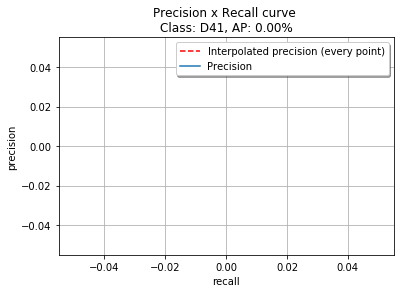

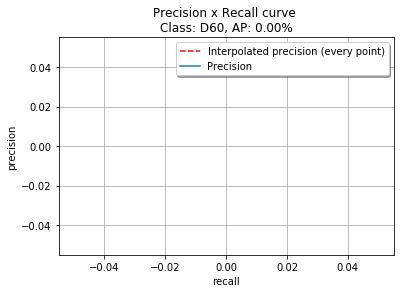

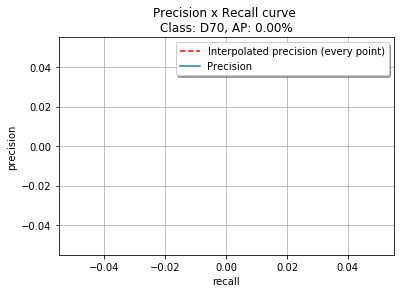

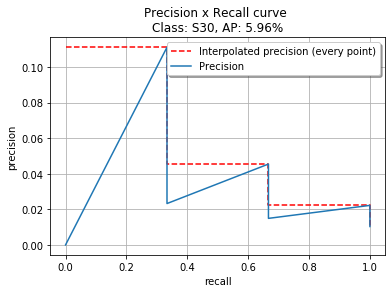

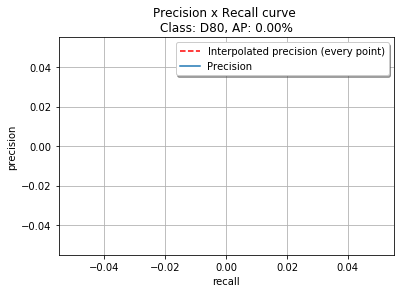

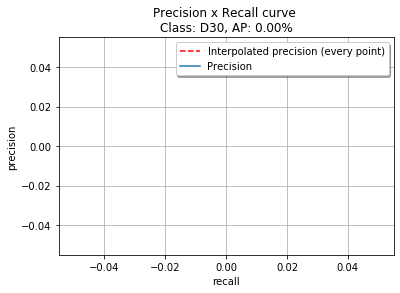

Mean average precision (mAP): 0.18931590266714907 at IoU threshold 0.01


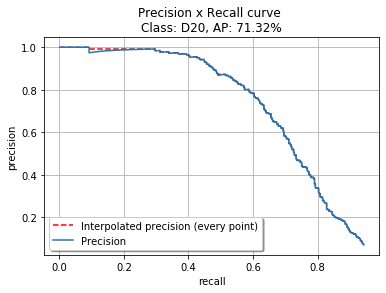

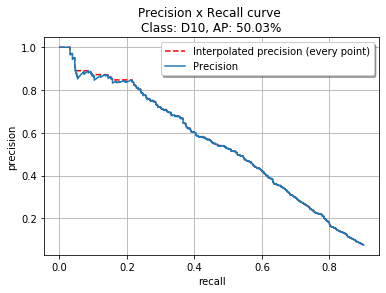

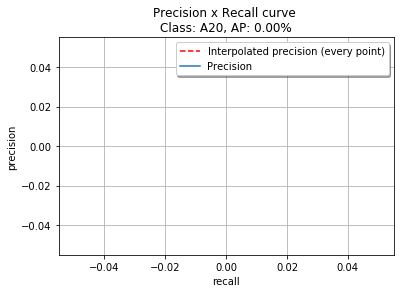

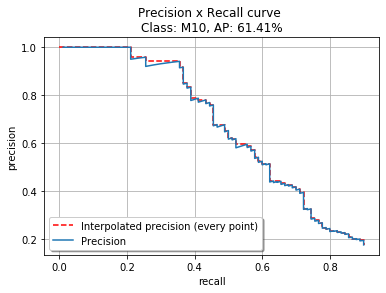

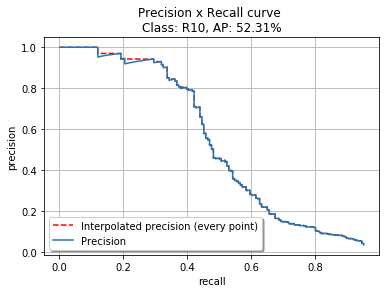

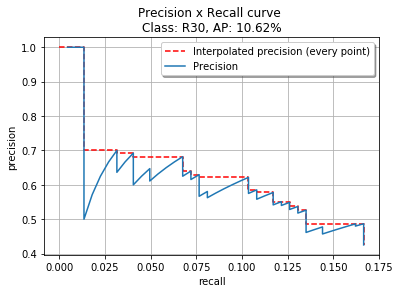

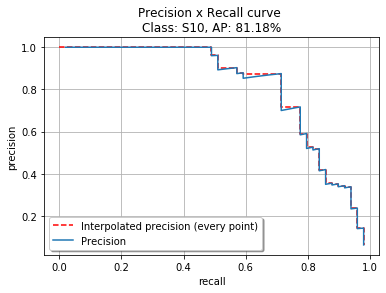

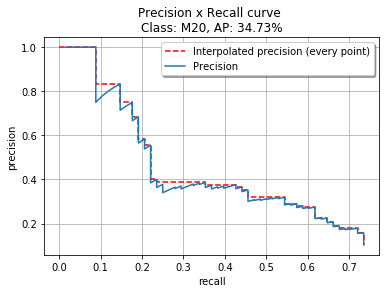

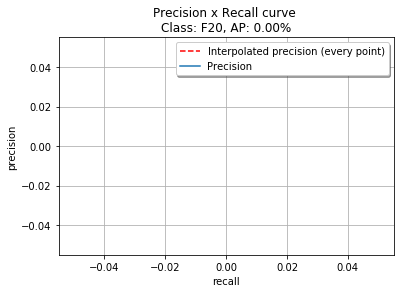

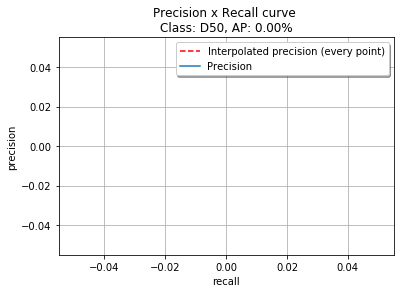

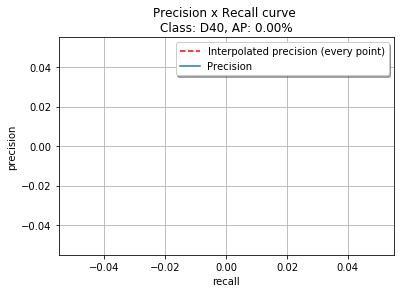

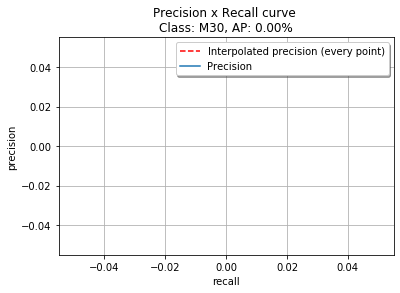

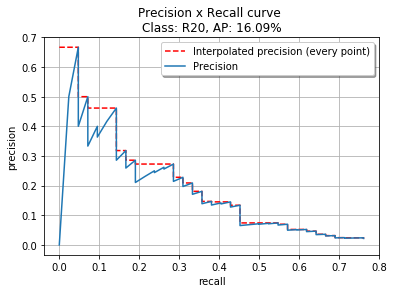

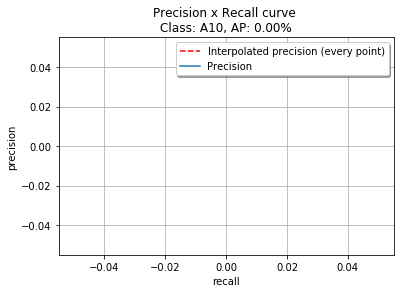

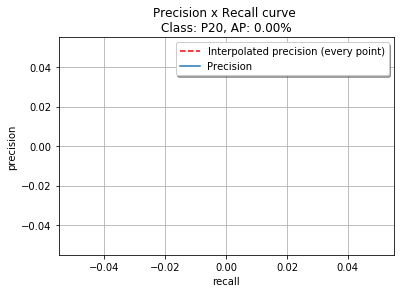

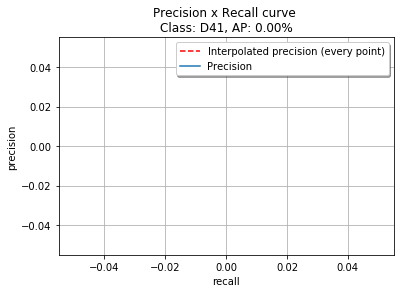

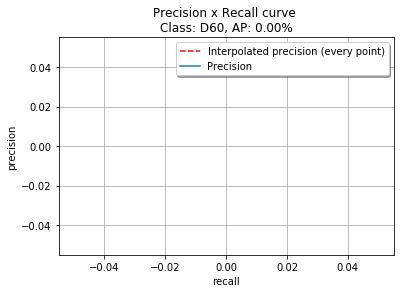

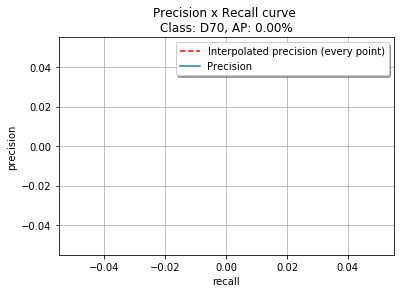

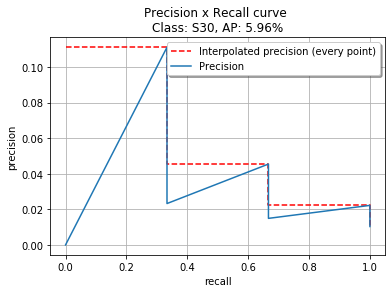

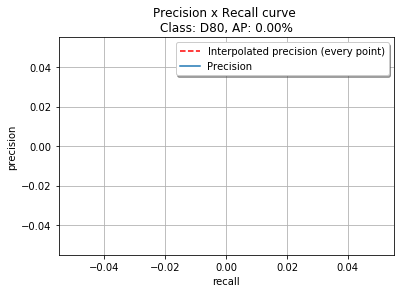

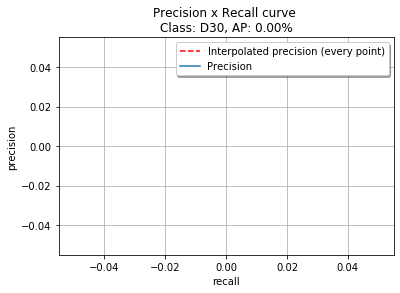

Mean average precision (mAP): 0.1826906413728384 at IoU threshold 0.2


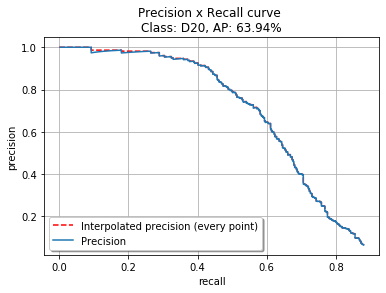

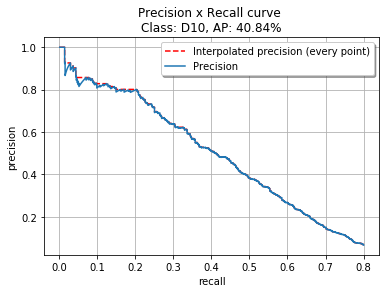

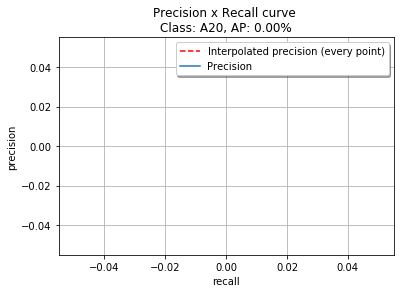

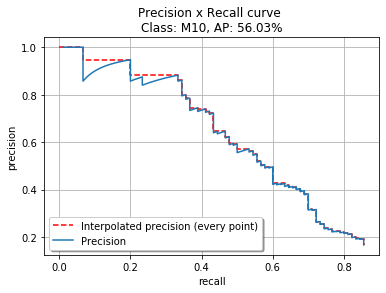

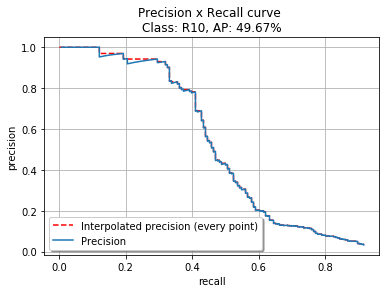

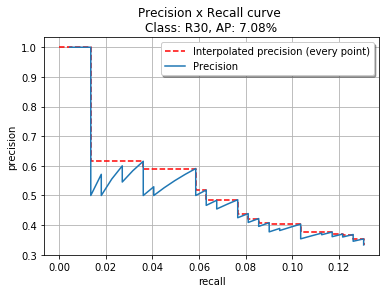

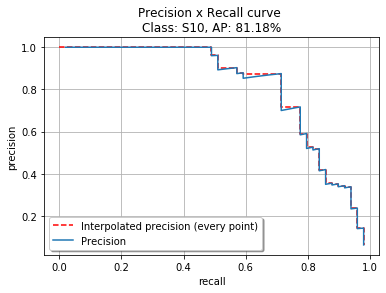

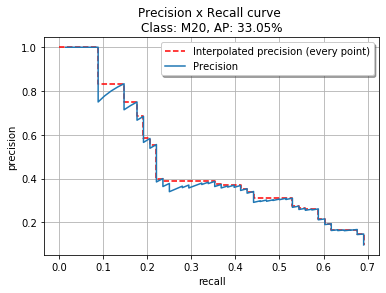

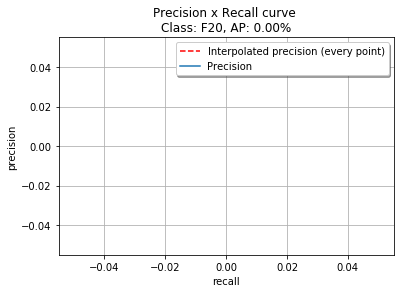

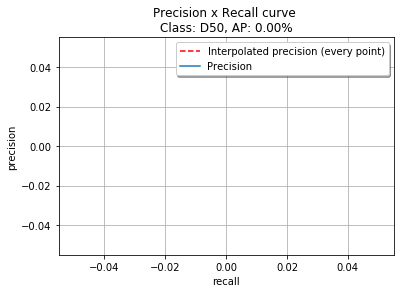

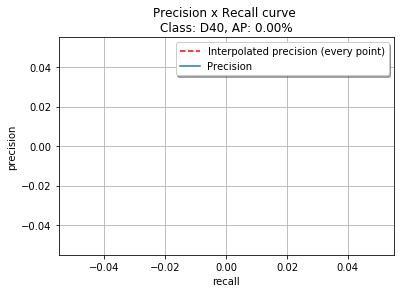

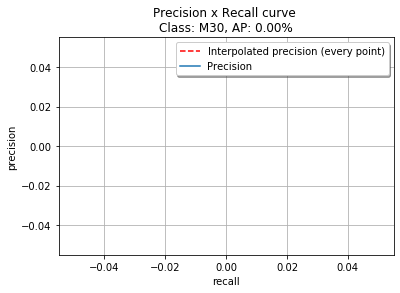

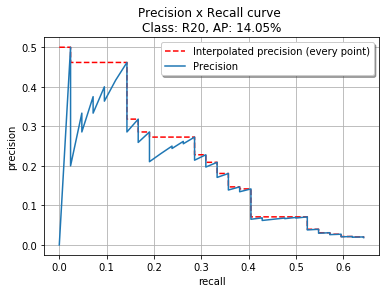

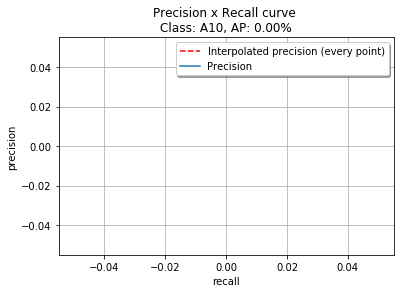

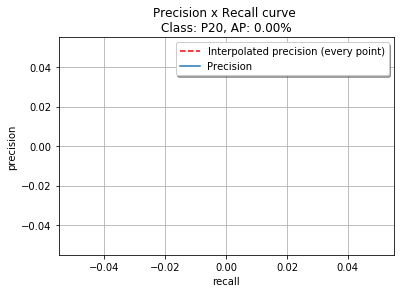

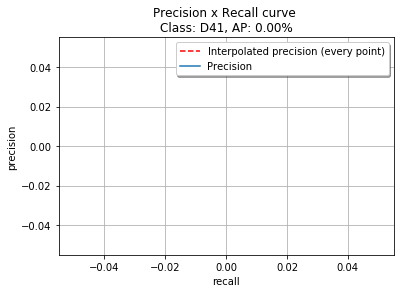

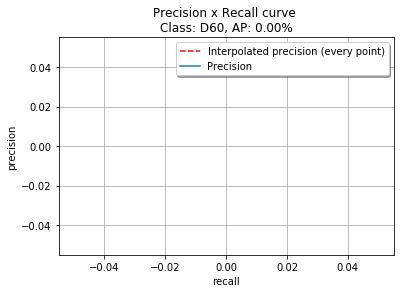

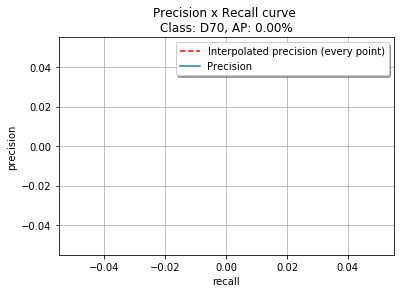

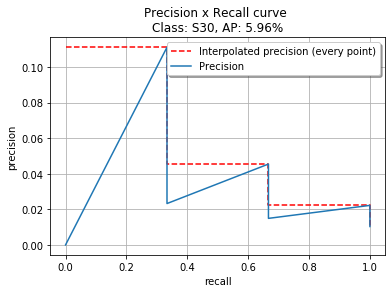

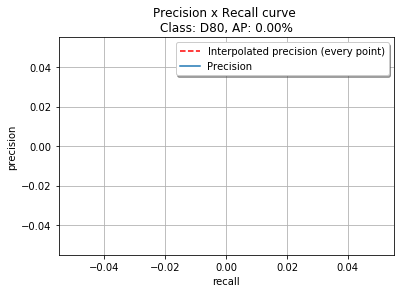

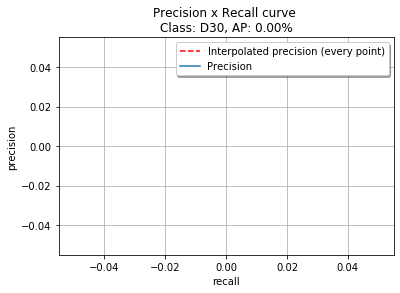

Mean average precision (mAP): 0.16752313584598025 at IoU threshold 0.5


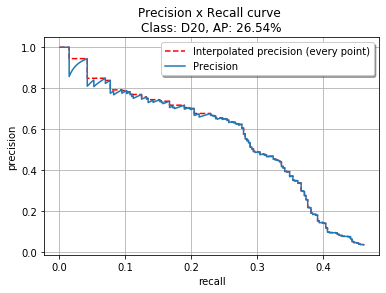

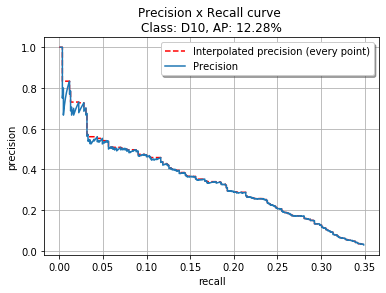

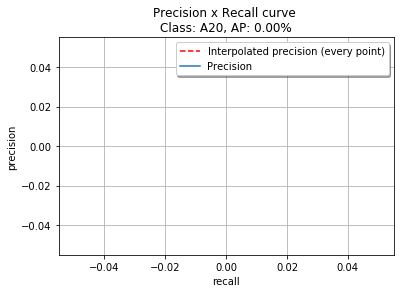

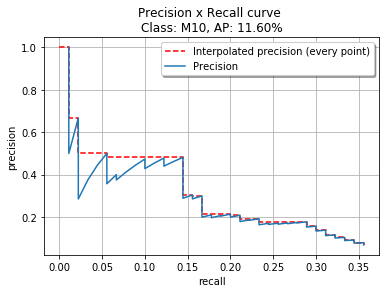

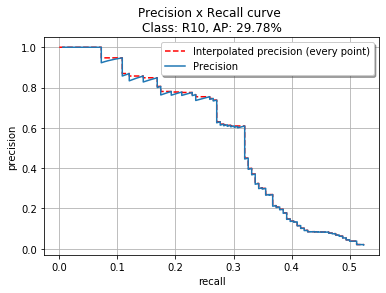

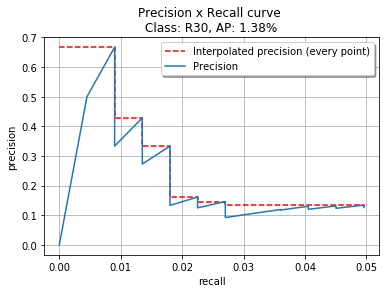

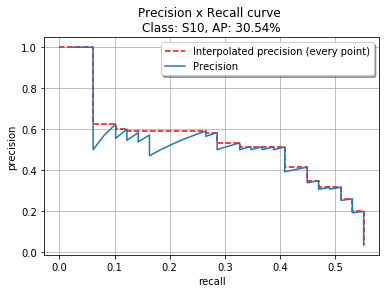

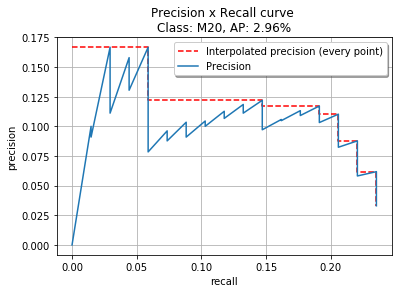

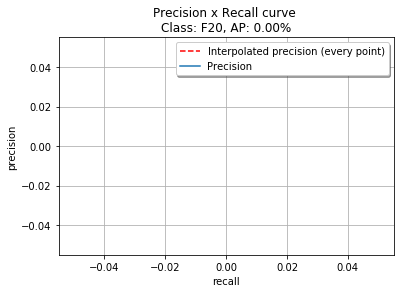

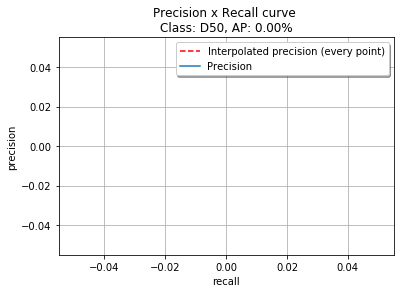

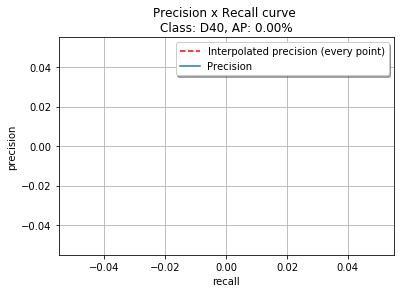

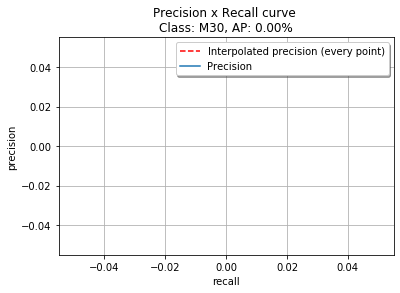

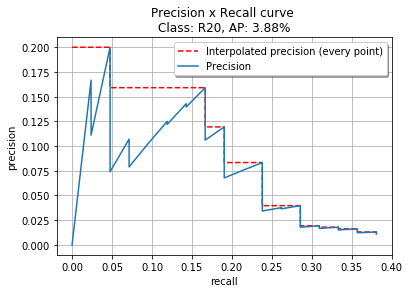

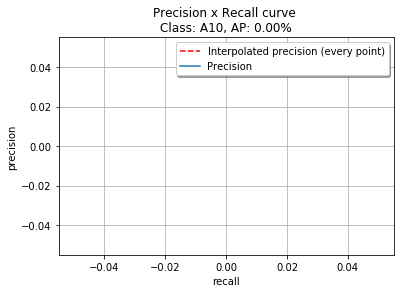

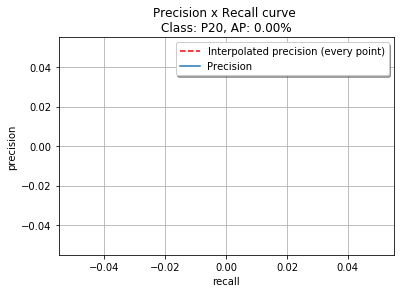

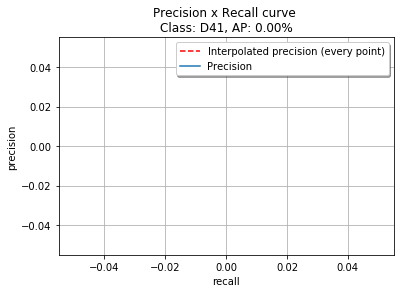

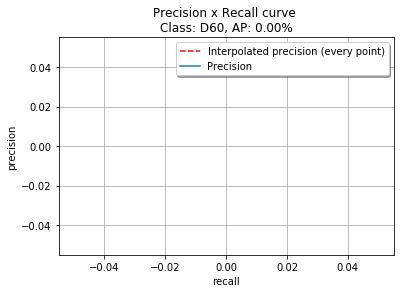

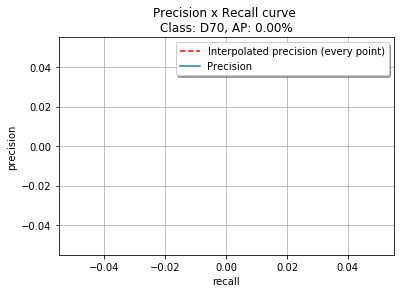

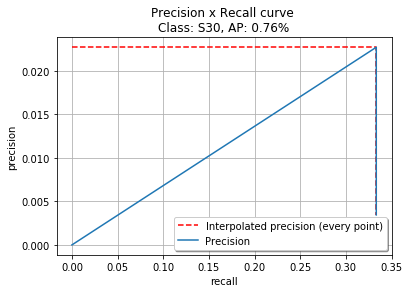

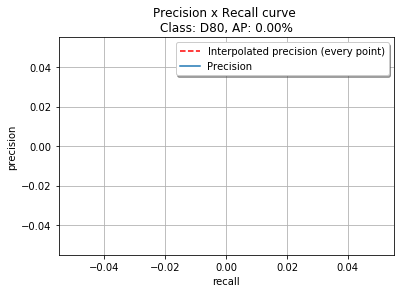

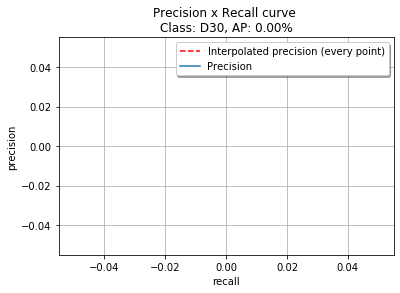

Mean average precision (mAP): 0.05700225219624841 at IoU threshold 0.75


In [29]:
ious = [0.01, 0.2, 0.5, 0.75]
voc_res = {}
for iou in ious:
    res = pascal_voc_evaluator.get_pascalvoc_metrics(gt_bbs, det_bbs, iou, generate_table=True, method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION)
    voc_res[iou], mAP = res['per_class'], res['mAP'] 
    pascal_voc_evaluator.plot_precision_recall_curves(voc_res[iou], showInterpolatedPrecision=True, showAP=True)

    print(f"Mean average precision (mAP): {mAP} at IoU threshold {iou}")